<a href="https://colab.research.google.com/github/Javed-ahmed-shanto/Deep-learning-for-developers/blob/main/ties4911_demo03_shanto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Number of classes: 2
Dataset info: tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur,

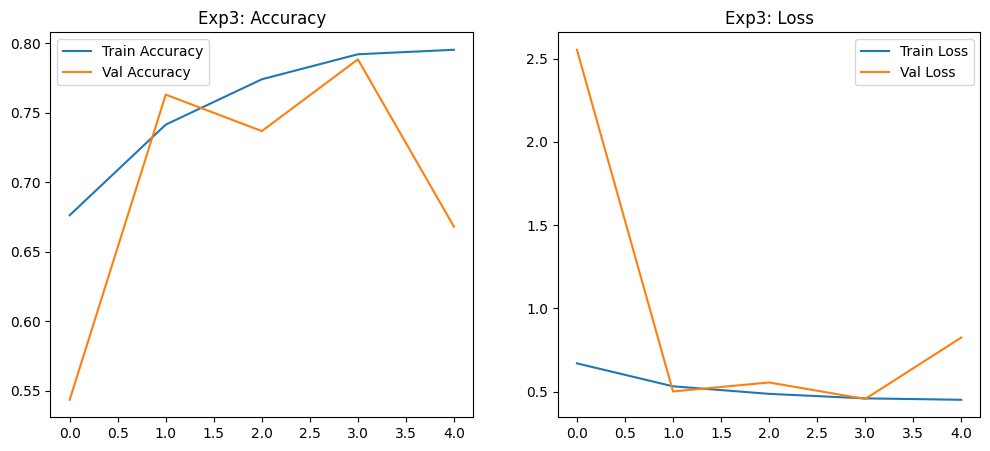

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers, regularizers

(train_ds_raw, val_ds_raw), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True
)

num_classes = ds_info.features['label'].num_classes
print("Number of classes:", num_classes)
print("Dataset info:", ds_info)

IMG_HEIGHT = 180
IMG_WIDTH = 180


def preprocess_image(image, label):
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    return image, label

def prepare_datasets(batch_size=32):
    train_ds = train_ds_raw.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(1000)
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

    val_ds = val_ds_raw.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(batch_size)
    val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds

def build_model(l2_reg, dropout_rate):
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ])

    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        data_augmentation,

        layers.Conv2D(16, (3,3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(32, (3,3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3,3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dropout(dropout_rate),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

EXPERIMENTS = [
    {
        "name": "Exp1",
        "batch_size": 32,
        "learning_rate": 0.001,
        "l2_reg": 1e-4,
        "dropout_rate": 0.5,
        "epochs": 5
    },
    {
        "name": "Exp2",
        "batch_size": 32,
        "learning_rate": 0.0005,
        "l2_reg": 1e-4,
        "dropout_rate": 0.5,
        "epochs": 5
    },
    {
        "name": "Exp3",
        "batch_size": 64,
        "learning_rate": 0.001,
        "l2_reg": 1e-5,
        "dropout_rate": 0.3,
        "epochs": 5
    },
]

results = []
for exp in EXPERIMENTS:
    print("="*50)
    print(f"Starting Experiment: {exp['name']}")
    print("="*50)

    train_ds, val_ds = prepare_datasets(batch_size=exp["batch_size"])

    model = build_model(l2_reg=exp["l2_reg"], dropout_rate=exp["dropout_rate"])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=exp["learning_rate"]),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=exp["epochs"],
        verbose=1
    )

    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]

    results.append({
        "Experiment": exp["name"],
        "Batch Size": exp["batch_size"],
        "Learning Rate": exp["learning_rate"],
        "L2 Reg": exp["l2_reg"],
        "Dropout": exp["dropout_rate"],
        "Epochs": exp["epochs"],
        "Final Train Acc": f"{train_acc:.4f}",
        "Final Val Acc": f"{val_acc:.4f}",
    })

import pandas as pd

df_results = pd.DataFrame(results)
print("\n===== EXPERIMENT RESULTS TABLE =====")
print(df_results.to_string(index=False))

last_history = history.history
epochs_range = range(exp["epochs"])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, last_history['accuracy'], label='Train Accuracy')
plt.plot(epochs_range, last_history['val_accuracy'], label='Val Accuracy')
plt.title(f"{exp['name']}: Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, last_history['loss'], label='Train Loss')
plt.plot(epochs_range, last_history['val_loss'], label='Val Loss')
plt.title(f"{exp['name']}: Loss")
plt.legend()
plt.show()